# NTU power consumption and generation - Data analysis and visualization

This notebook aims to analyze trends in the data for consumption of NTU buildings given by ODFM.
It consists of visualizing the distribution of data values, and also the distribtion of data over different periods (hours or months) to observe certain trends that can help understanding the data better. 
This knowledge will be used in deciding which machine learning model should be used for NTU's buildings consumption forecasting and how to train the model to maximize its performance.

In [1]:
# Import libraries the libraries required
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.dates as mdates
style.use('ggplot')
sb.set()
import warnings
warnings.filterwarnings("ignore")

As observed below, the dataset has been prepared to obtain real and reactive power from all NTU buildings, Furthermore, it also includes the power generated by NTU solar panels. An assumption is taken that it is evenly distibuted (same power generated by each building) since we lack information on NTU's network topology.

In [2]:
# Extract from the dataset table 2.6 (the one to be used in our classification problem)
NTU_Power = pd.read_excel('NNData.xlsx', index_col=0)
NTU_Power.head(5)

,Hour,Day of Week,Month,NEC_P,NEC_Q,CANTEEN_2_P,CANTEEN_2_Q,SPMS_P,SPMS_Q,RTP_P,...,THE_WAVE_P,THE_WAVE_Q,HALL_4_P,HALL_4_Q,EMB_P,EMB_Q,NYA_P,NYA_Q,NYH_P,Building_P
TIME,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,0,4,1,297.599840,57.360012,209.69993,39.000000,2662.0004,1060.99997,421.200002,...,23.899985,-5.200005,111.59994,-32.80001,1017.07703,0.402891,27.700012,4.000014,43.99999,0.0
2020-01-01 01:00:00,1,4,1,273.200038,56.640105,187.40000,24.800008,2635.0006,1053.00015,416.100030,...,23.700000,-5.000000,99.80003,-32.09999,1028.20990,8.366951,27.199999,4.600000,45.50000,0.0
2020-01-01 02:00:00,2,4,1,267.599995,58.759954,170.79999,35.399950,2673.0006,1079.00030,445.999890,...,23.400001,-4.900002,105.99997,-34.39999,1041.81469,1.116322,27.100000,3.999958,46.69992,0.0
2020-01-01 03:00:00,3,4,1,266.011430,56.320000,176.80012,31.600101,2622.0004,1078.00010,430.099970,...,23.200000,-5.200000,106.59999,-32.30001,1023.37623,24.023428,25.300030,0.900065,42.90001,0.0
2020-01-01 04:00:00,4,4,1,268.406032,57.246219,179.59993,39.300000,2653.0003,1078.00000,415.600017,...,22.800000,-4.900000,103.99990,-33.50002,1014.89830,3.295560,28.499998,4.000000,47.60005,0.0


In [3]:
Irradiation_P=pd.DataFrame(NTU_Power["Building_P"])
Irradiation_P.describe()

,Building_P
count,8784.000000
mean,62.857673
std,94.139290
min,-35.357143
25%,0.000000
50%,0.598214
75%,105.195685
max,393.696429


<AxesSubplot:ylabel='Count'>

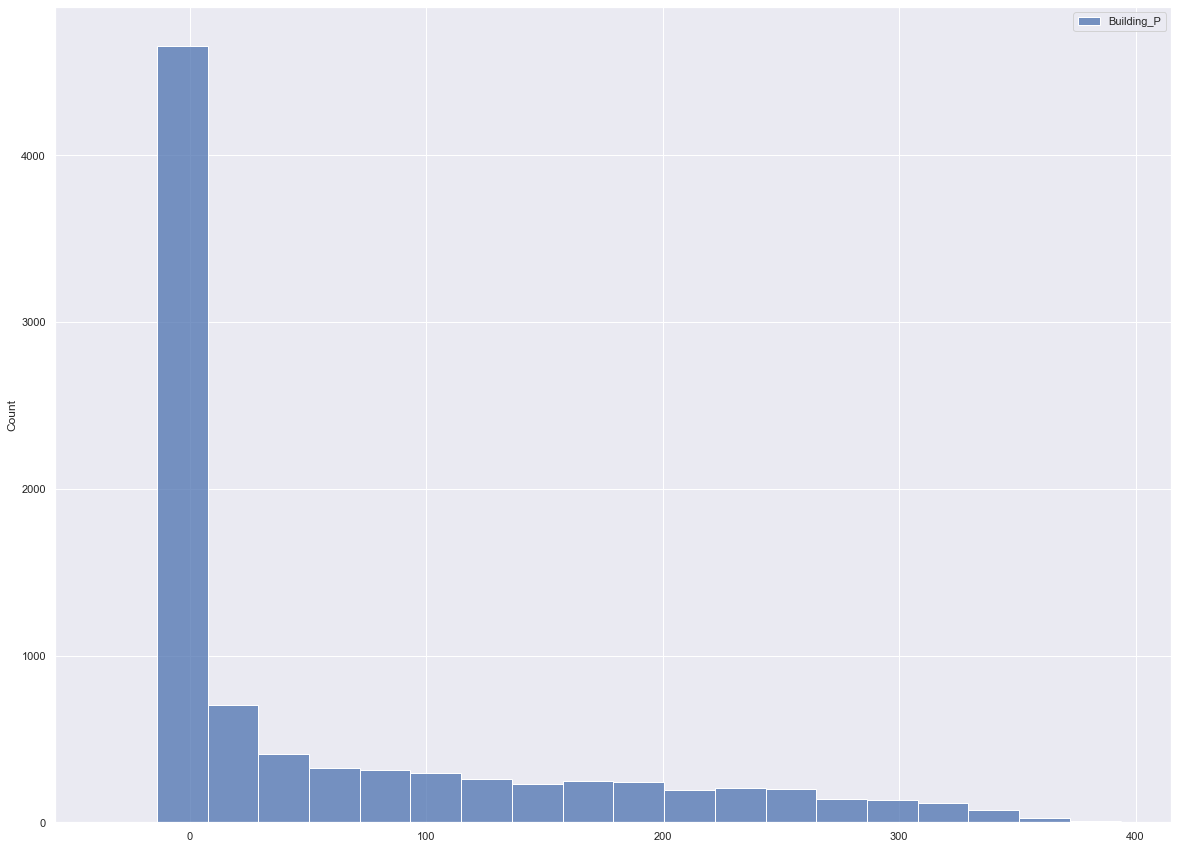

In [4]:
# Draw the distributions
f, axes = plt.subplots(1, 1, figsize=(20, 15))
sb.histplot(Irradiation_P, bins=20)

Two interesting fetures can be observed.

Surprisingly enough, there is a negative value in power generated by the solar PVs. This is most likely caused by a meter that provided a wrong value. It can be solved by the following code:

In [5]:
Irradiation_P[Irradiation_P < 0] = 0
Irradiation_P.describe()

,Building_P
count,8784.000000
mean,62.894427
std,94.112217
min,0.000000
25%,0.000000
50%,0.598214
75%,105.195685
max,393.696429


It is observed below that irradiation is distributed  quite unevenly, as almost half of the dataset corresponds to a meter reading of zero irradiance, which occurs at night time or under shading conditions. This coincides with intuition, since Singapore is close to the equator, hence receiving sunlight approximately half the hours of the day. It is shown in the following figure, representing Singapore's sun path, where green and orange lines represent the equinoces.


![alt text](Singapore_sun_path.png "Singapore's sun path")


This will later prove to be a feature of the data available which will hinder the construction of more effective ML models, as correlation of irradiation with buildings power consumption indicates that the variable can give an edge in the training of the model. Therefore, having several zero irradiance values is detrimental for the use of this variable in the model.

# NTU Buildings Power Consumption - data trends

In [6]:
# Separate data in active and reactive power
P_Buildings = pd.DataFrame(NTU_Power[["NEC_P", "CANTEEN_2_P", "SPMS_P", "RTP_P", "N1_3_P", "N_2_P", 
                                      "N_2_1_P", "SBS_P", "PIONEER_HALL_P", "THE_WAVE_P", "HALL_4_P", 
                                      "EMB_P", "NYA_P", "NYH_P"]])
Q_Buildings = pd.DataFrame(NTU_Power[["NEC_Q", "CANTEEN_2_Q", "SPMS_Q", "RTP_Q", "N1_3_Q", 
                                      "N_2_Q", "N2_1_Q", "SBS_Q", "PIONEER_HALL_Q", 
                                      "THE_WAVE_Q", "HALL_4_Q", "EMB_Q", "NYA_Q"]])

## Active power data analysis

In [7]:
# Main building active power consumption data statistics
P_Buildings.describe()

,NEC_P,CANTEEN_2_P,SPMS_P,RTP_P,N1_3_P,N_2_P,N_2_1_P,SBS_P,PIONEER_HALL_P,THE_WAVE_P,HALL_4_P,EMB_P,NYA_P,NYH_P
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,327.825934,316.523048,2754.449906,574.066322,809.829669,225.095833,365.542051,2430.267723,211.963162,40.462991,179.313233,1124.050694,-47.386364,88.569088
std,98.288136,100.637456,222.084823,136.613122,116.359056,42.698965,215.314072,285.505268,82.096815,38.590922,69.690610,96.494328,118.836021,71.423400
min,120.700100,0.000000,2061.999200,329.700230,323.000800,14.041491,103.000100,1473.171310,22.199950,13.500000,61.199970,651.523180,-521.899390,-15.599890
25%,280.199975,234.575010,2644.000275,465.175040,717.999987,203.999942,185.999828,2202.000840,154.600153,21.500000,122.699990,1055.213393,-110.750102,39.599962
50%,312.099898,307.600080,2797.000500,523.450071,785.999330,222.700030,268.000055,2352.900050,197.050025,25.199975,165.500045,1107.201770,24.200016,71.200040
75%,355.524973,386.800000,2904.999825,701.225730,892.999947,243.899870,562.000375,2630.499925,262.000000,35.599992,221.425065,1185.635348,28.700000,110.000005
max,986.600163,606.899800,3252.999800,911.900070,1226.998700,384.500000,906.999230,3266.396000,499.400000,211.700100,395.100100,1671.440870,173.400010,566.100100


<AxesSubplot:>

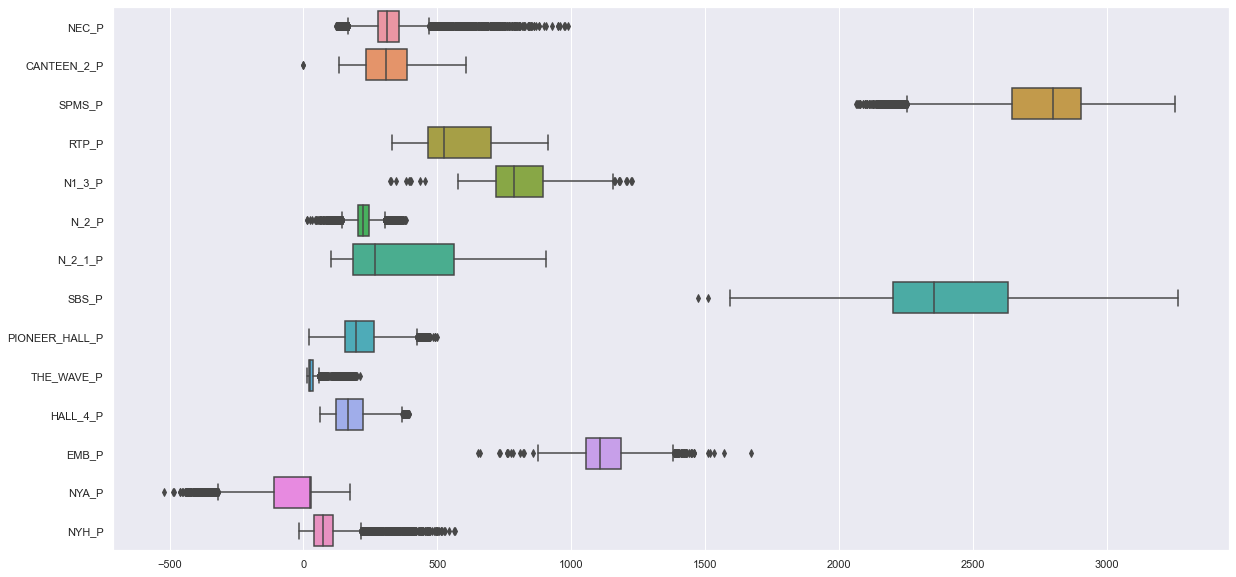

In [8]:
# Draw the Boxplots of active power of all buildings
f, axes = plt.subplots(1, 1, figsize=(20, 10))
sb.boxplot(data = P_Buildings, orient = "h")

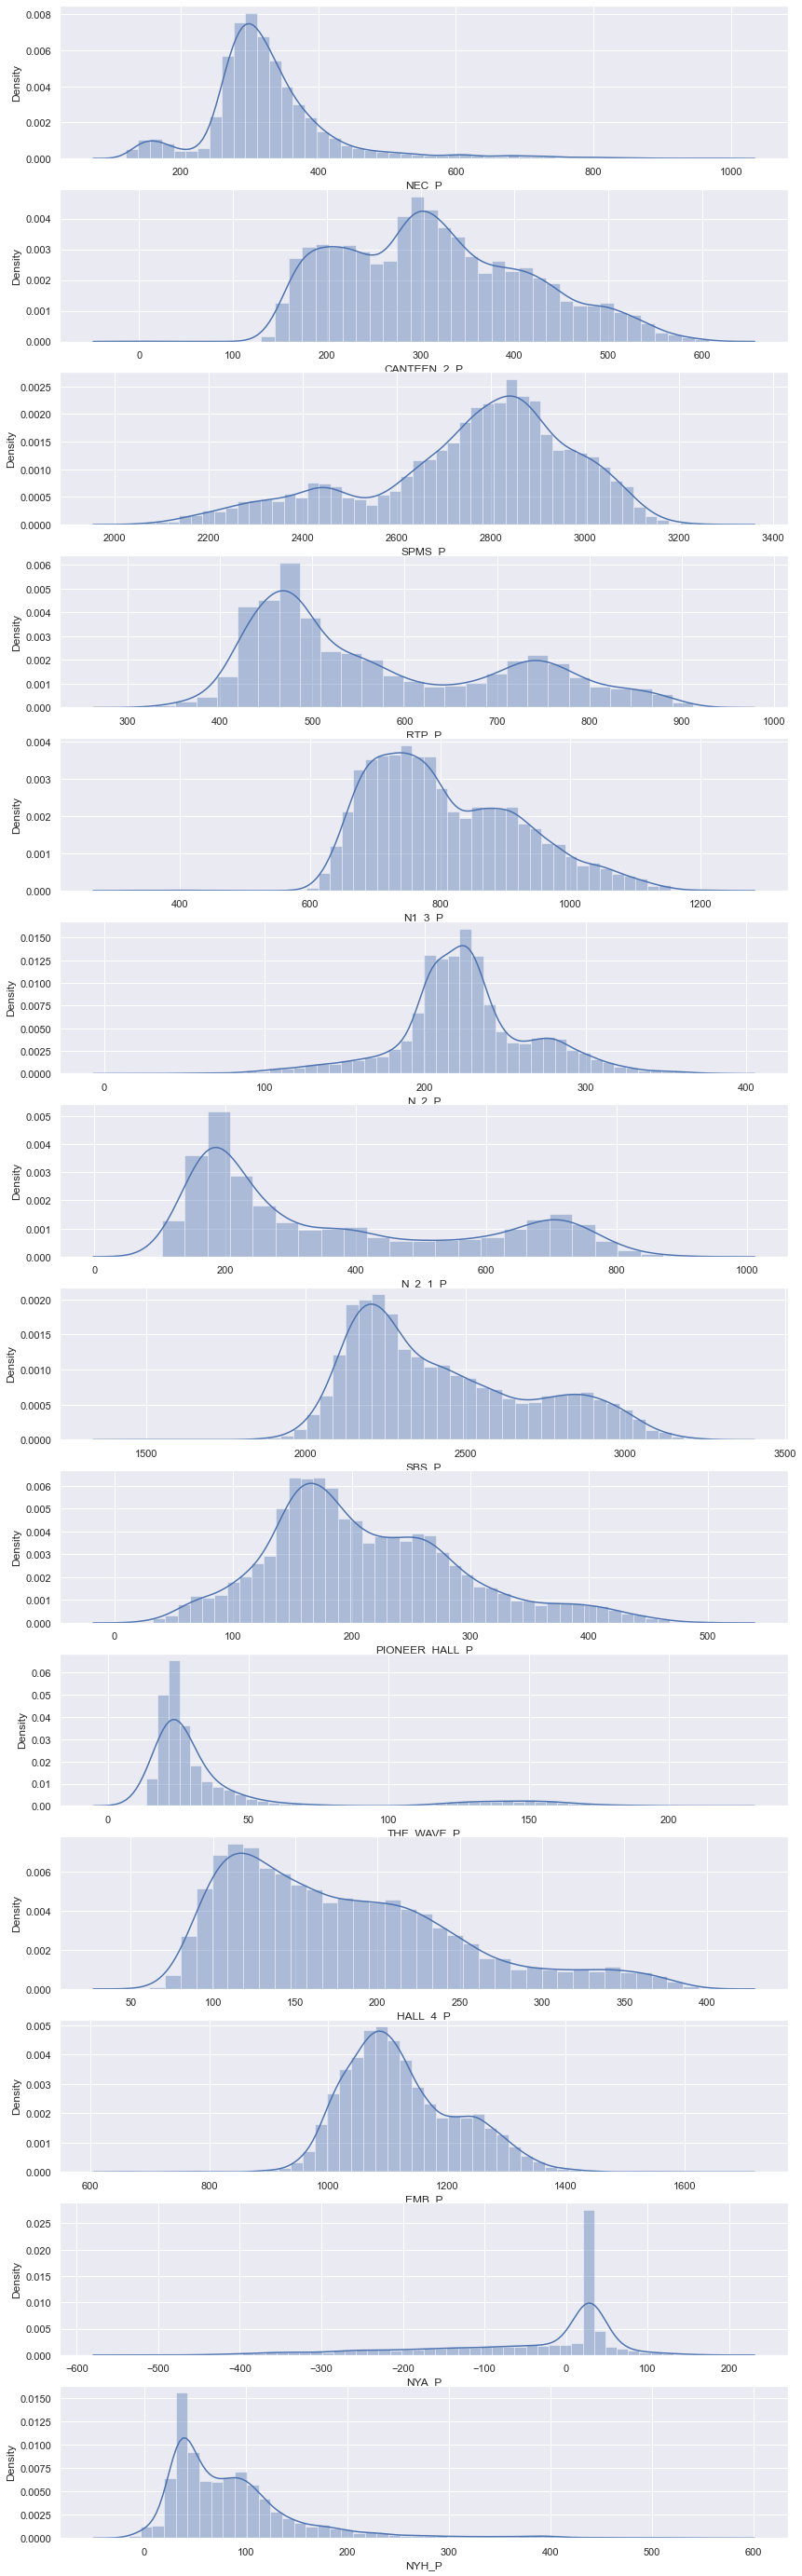

In [9]:
# Draw the distributions of all variables
f, axes = plt.subplots(14, figsize=(14, 50))

count = 0
for var in P_Buildings:
    sb.distplot(P_Buildings[var], ax = axes[count,])
    count += 1

Observations:
- NYA power has several negative readings. It's meter must be wrong. 
- Distribution of power in the buildings is not normal at all. Hence, it is worth trying to normalize it during the pre-processing process of the ML model data.
- The scales are very different from those of hour, day or month, hence these data needs to be escalated before using it in the ML model as part of pre-processing.
- Many of the distributions have several outliers.

## Reactive Power data analysis

In [10]:
# Main building active power consumption data statistics
Q_Buildings.describe()

,NEC_Q,CANTEEN_2_Q,SPMS_Q,RTP_Q,N1_3_Q,N_2_Q,N2_1_Q,SBS_Q,PIONEER_HALL_Q,THE_WAVE_Q,HALL_4_Q,EMB_Q,NYA_Q
count,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000,8784.000000
mean,94.847151,52.354472,1092.647391,250.885170,193.430950,32.657740,129.146893,636.108787,34.825077,-3.971790,-30.427383,11.215213,11.346649
std,54.522427,16.090045,49.599546,54.085221,41.553713,22.106843,85.507356,95.292276,24.224091,2.681171,14.034761,20.506532,11.324395
min,8.240147,8.400082,795.365160,104.600019,25.000020,-7.999990,12.000000,432.200030,-70.099890,-12.999857,-63.799990,-81.226208,-15.299996
25%,64.960060,40.600041,1065.999978,214.400006,165.000150,18.099813,55.000000,554.599878,22.600051,-5.300000,-42.900010,-2.398934,4.100053
50%,82.220018,53.099980,1099.000365,234.100006,191.000210,27.899997,97.000000,608.000090,35.500082,-4.600000,-28.399992,9.996944,8.875745
75%,106.520013,64.599990,1127.250448,305.000001,219.000100,42.425031,211.999987,723.600058,49.412755,-3.600000,-19.099996,23.497684,14.300012
max,359.920059,90.599800,1245.999680,363.999803,376.999840,163.899988,312.999863,884.499660,127.499390,13.200000,12.100003,101.970699,75.999990


<AxesSubplot:>

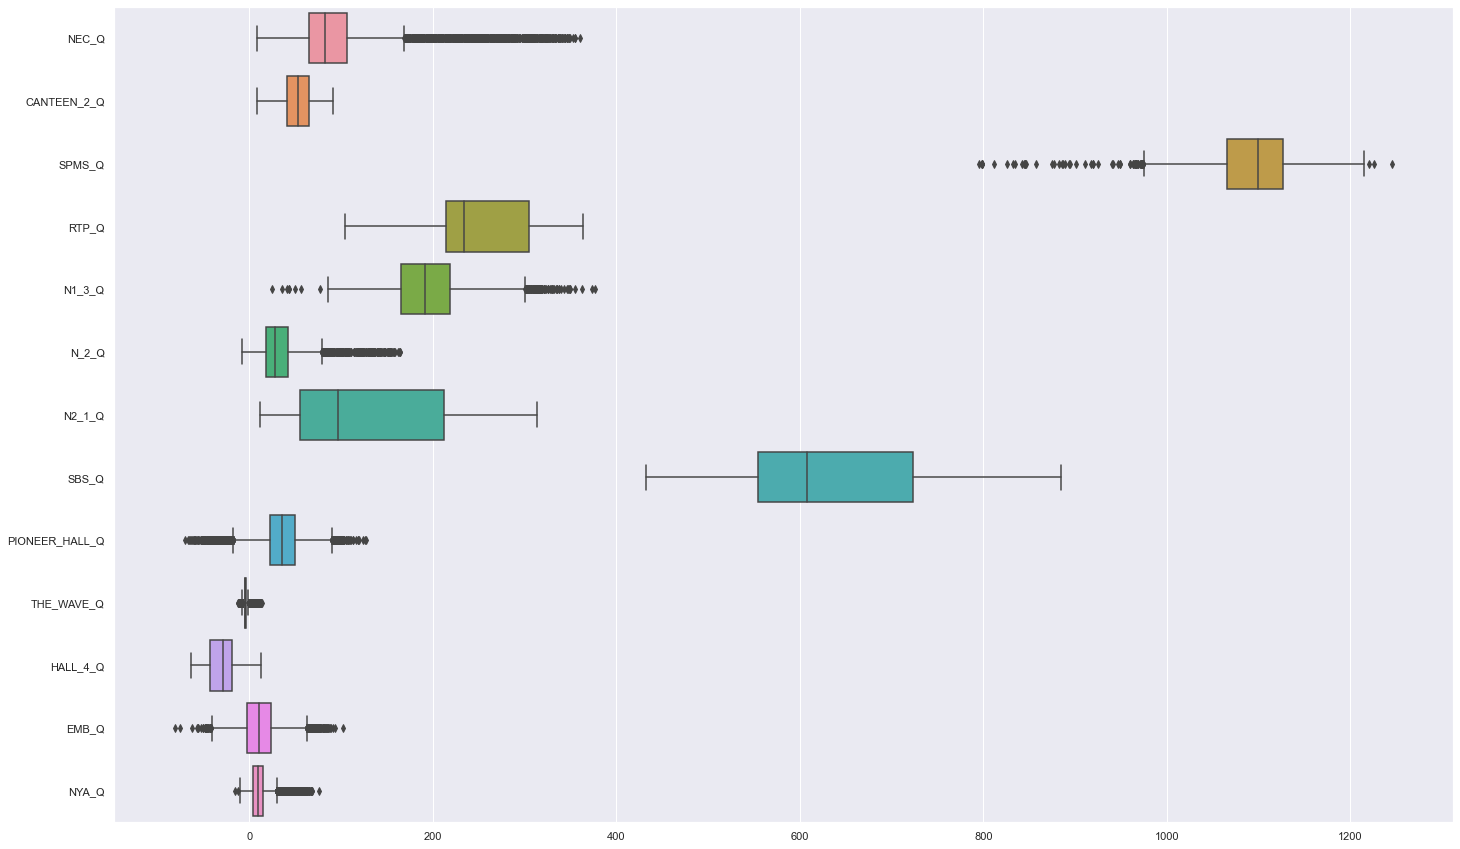

In [11]:
# Draw the Boxplots of active power of all buildings
f, axes = plt.subplots(1, 1, figsize=(24, 15))
sb.boxplot(data = Q_Buildings, orient = "h")

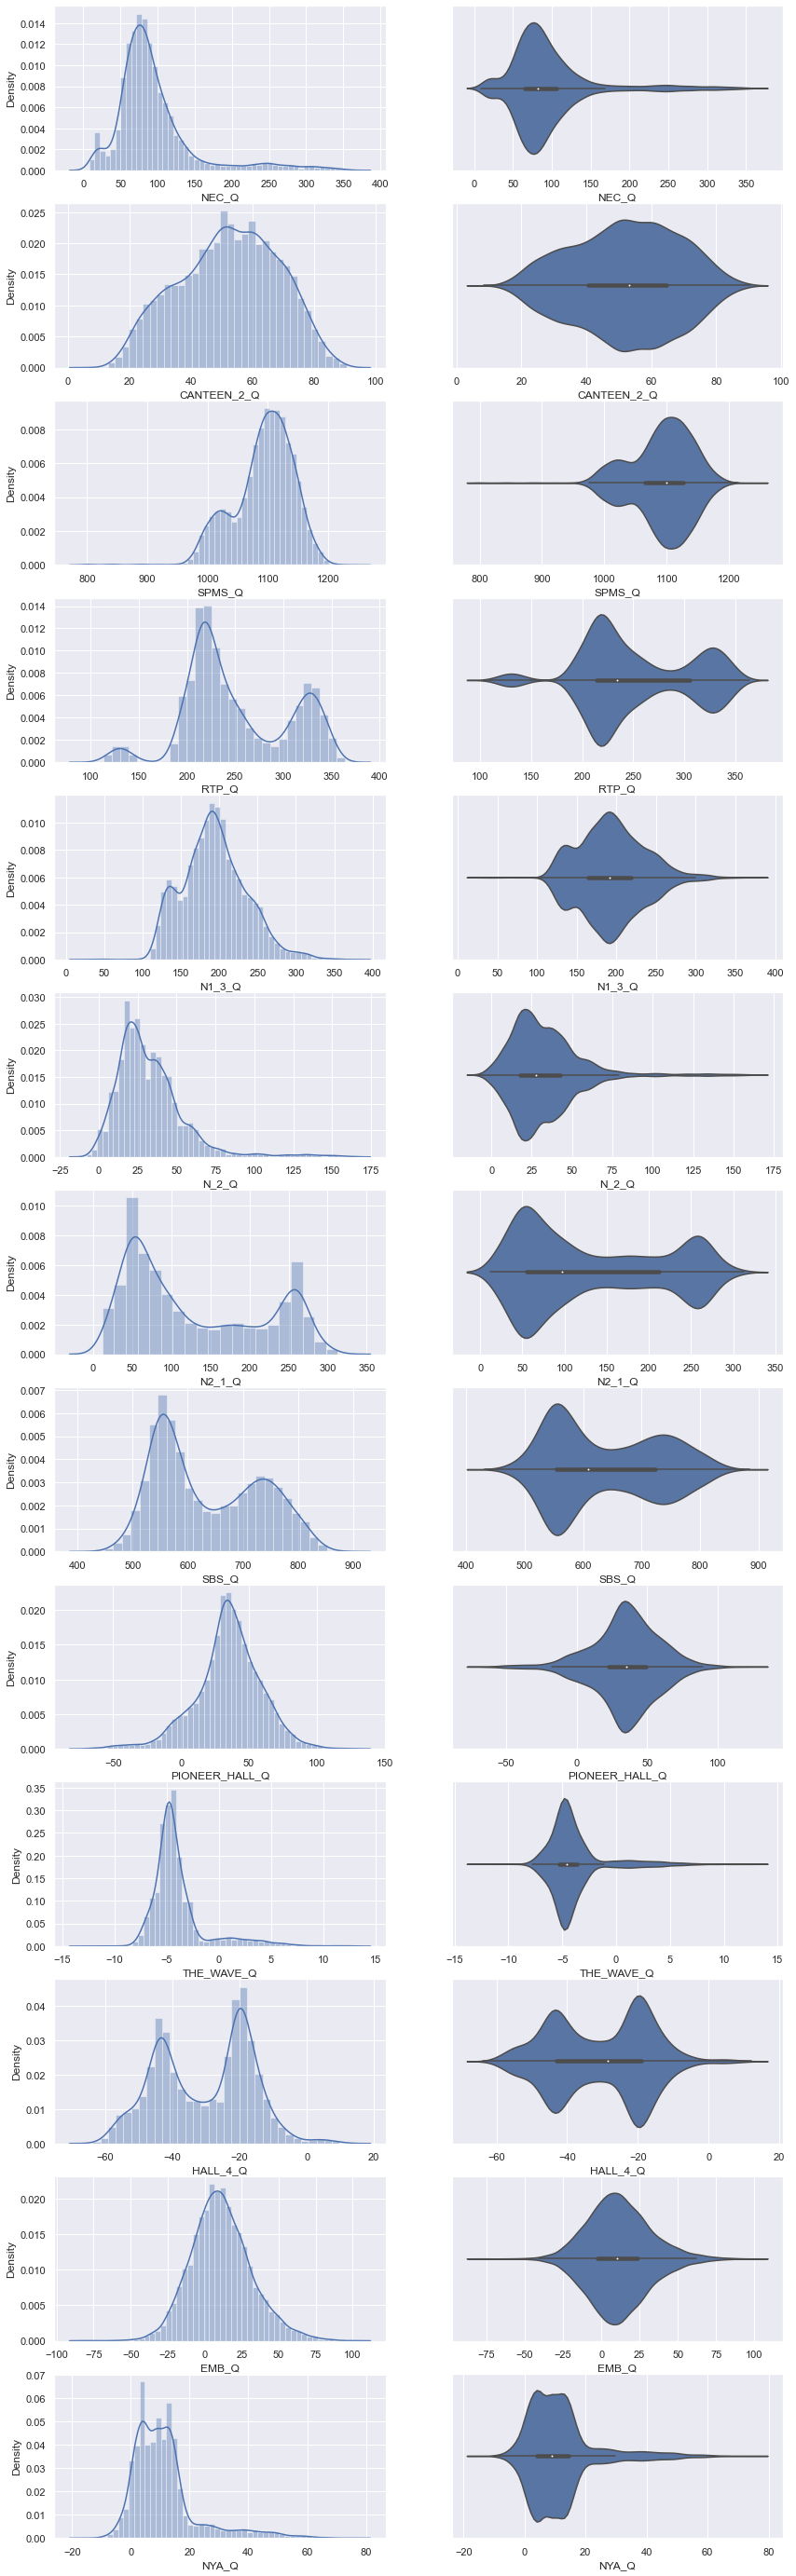

In [12]:
# Draw the distributions of all variables
f, axes = plt.subplots(13, 2, figsize=(14, 50))

count = 0
for var in Q_Buildings:
    sb.distplot(Q_Buildings[var], ax = axes[count,0])
    sb.violinplot(Q_Buildings[var], ax = axes[count,1])
    count += 1

Observations are very similarto those of active power: 
- Distribution of power in the buildings is not normal at all. Hence, it is worth trying to normalize it during the pre-processing process of ML model data.
- The scales are very different from those of hour, day or month, hence these data needs to be escalated before using it in the ML model as part of pre-processing.
- Many of the distributions have several outliers.

# NTU Network - Plot Power of buildings day of the week

<AxesSubplot:xlabel='Day of Week', ylabel='HALL_4_P'>

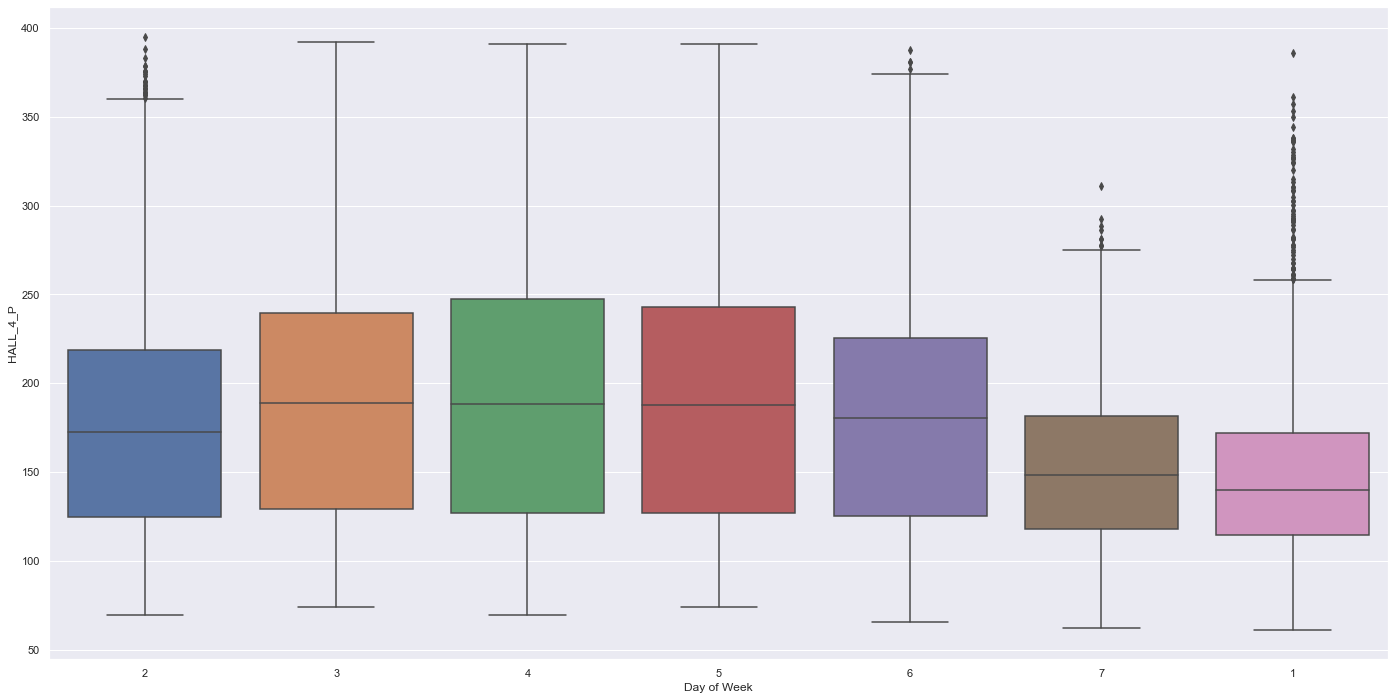

In [13]:
# First we can create dataframes for each of the building active or reactive power
# For this plot, Hall 4 is chosen arbitrarily
# It includes the hour, weekday and month of each data point, and also the power
df = pd.DataFrame(NTU_Power[["Hour", "Day of Week", "Month", "HALL_4_P"]])

f, axes = plt.subplots(1, 1, figsize=(24, 12))
# Order is incorporated to show the days from Monday to Sunday
sb.boxplot( x="Day of Week", y="HALL_4_P", hue=None, data=df, order=(2, 3, 4, 5, 6, 7, 1), hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None)

<AxesSubplot:xlabel='Month', ylabel='HALL_4_P'>

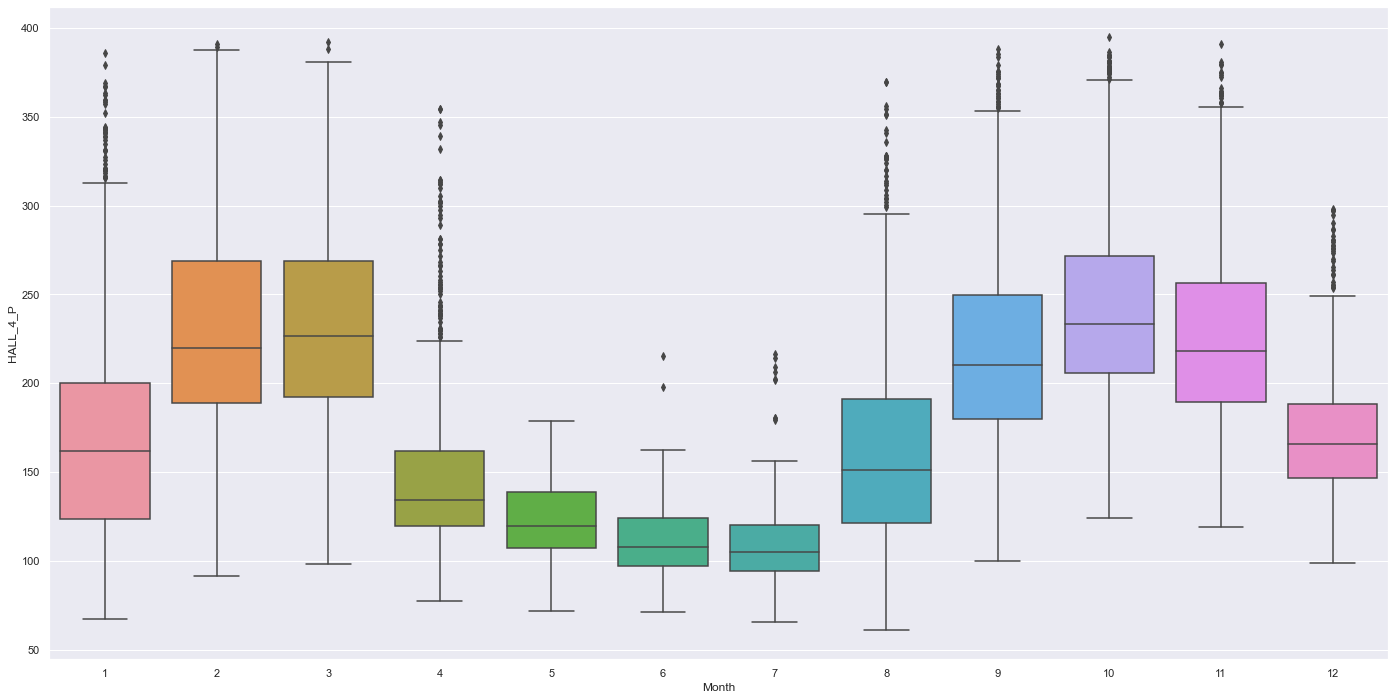

In [14]:
f, axes = plt.subplots(1, 1, figsize=(24, 12))
sb.boxplot( x="Month", y="HALL_4_P", hue=None, data=df, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, width=0.8, dodge=True, fliersize=5, linewidth=None, whis=1.5, ax=None)

It is observed how the day of the week and the month of the year have defined trends in Hall 4. For other variables this could also be observed. Hence it is possible to leverage this variables in a machine learning model.

# Plot Power of buildings against hours per day for the first week

In [15]:
# This can be done by creating a new variable in the dataset that accounts for the hours in the year
# This is, hours for the first day of the year will be 0 to 23, for the second day 24 to 47...
# Then just print a  plot

df = pd.DataFrame(NTU_Power[["Hour", "Day of Week", "Month", "THE_WAVE_P"]])
Hour = pd.DataFrame(df["Hour"])
df["Hour_Count"] = np.zeros(Hour.shape)
for i in range(0, df.shape[0]):
    df["Hour_Count"][i]=i

df.head(10)

,Hour,Day of Week,Month,THE_WAVE_P,Hour_Count
TIME,,,,,
2020-01-01 00:00:00,0,4,1,23.899985,0.0
2020-01-01 01:00:00,1,4,1,23.700000,1.0
2020-01-01 02:00:00,2,4,1,23.400001,2.0
2020-01-01 03:00:00,3,4,1,23.200000,3.0
2020-01-01 04:00:00,4,4,1,22.800000,4.0
2020-01-01 05:00:00,5,4,1,22.700010,5.0
2020-01-01 06:00:00,6,4,1,23.700010,6.0
2020-01-01 07:00:00,7,4,1,26.400035,7.0
2020-01-01 08:00:00,8,4,1,17.000010,8.0


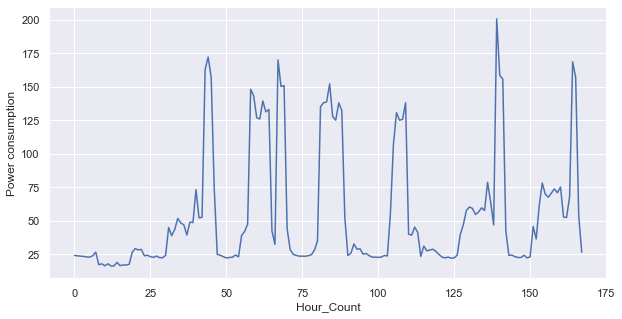

In [16]:
# But better plot it for one week only as it will be clearer
df1 = df.iloc[0:(24*7), ]
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set(xlabel='Hour_Count', ylabel='Power consumption')
ax1.plot(df1["Hour_Count"], df1["THE_WAVE_P"], color='b')

In a similar manner as day of the week and month, the hour of the day also shows potential as an input of a machine learning model.

# NTU Network - Correlation between consumption and PV generation

The idea behind this correlation test is that we expect higher temperatures when solar irradiance (and hence PV power generation) is higher, which should lead to higher consumption by NTU buildings.

In [17]:
# Correlation Matrix of the dataset
NTU_Power.corr()

,Hour,Day of Week,Month,NEC_P,NEC_Q,CANTEEN_2_P,CANTEEN_2_Q,SPMS_P,SPMS_Q,RTP_P,...,THE_WAVE_P,THE_WAVE_Q,HALL_4_P,HALL_4_Q,EMB_P,EMB_Q,NYA_P,NYA_Q,NYH_P,Building_P
Hour,1.000000e+00,-1.639924e-18,2.573421e-15,0.463005,0.366917,0.459437,0.491475,0.167963,0.027869,0.258867,...,0.256001,0.236416,0.099438,0.379380,0.256679,0.012339,-0.072776,0.144461,0.289897,0.081714
Day of Week,-1.639924e-18,1.000000e+00,-7.345951e-03,0.003113,0.017422,0.014868,0.035131,0.056252,0.056583,0.044995,...,0.027478,0.023634,0.004499,-0.017313,0.064551,0.021710,0.015643,0.017432,0.017092,-0.010182
Month,2.573421e-15,-7.345951e-03,1.000000e+00,-0.322844,-0.214658,-0.246111,-0.032660,0.290019,0.138468,0.155417,...,-0.114400,-0.080596,0.081767,0.064968,0.158990,0.223085,0.041969,-0.005312,-0.009313,-0.045849
NEC_P,4.630054e-01,3.112579e-03,-3.228435e-01,1.000000,0.789302,0.540839,0.408760,0.313265,0.178457,0.155593,...,0.519500,0.412553,0.310502,0.118042,0.194036,-0.046910,0.063492,0.018794,0.639859,-0.076676
NEC_Q,3.669172e-01,1.742170e-02,-2.146582e-01,0.789302,1.000000,0.580983,0.463258,0.336639,0.244214,0.405208,...,0.675259,0.519695,0.215487,0.315463,0.370938,0.076970,-0.148698,0.272976,0.528299,0.169216
CANTEEN_2_P,4.594372e-01,1.486755e-02,-2.461113e-01,0.540839,0.580983,1.000000,0.889190,0.444893,0.422722,0.591833,...,0.520307,0.429688,0.462589,0.486927,0.492908,0.093483,-0.295176,0.374531,0.531629,0.388914
CANTEEN_2_Q,4.914748e-01,3.513103e-02,-3.266030e-02,0.408760,0.463258,0.889190,1.000000,0.384580,0.375029,0.634088,...,0.408938,0.380912,0.393618,0.542889,0.529955,0.134959,-0.332727,0.387289,0.429546,0.443307
SPMS_P,1.679633e-01,5.625196e-02,2.900194e-01,0.313265,0.336639,0.444893,0.384580,1.000000,0.842848,0.333651,...,0.321712,0.183076,0.579330,0.020875,0.384094,0.208492,0.128323,0.030786,0.538503,-0.126804
SPMS_Q,2.786911e-02,5.658316e-02,1.384676e-01,0.178457,0.244214,0.422722,0.375029,0.842848,1.000000,0.269183,...,0.249208,0.153255,0.544721,-0.005329,0.281610,0.154237,0.014837,0.055665,0.421359,-0.002043
RTP_P,2.588670e-01,4.499541e-02,1.554169e-01,0.155593,0.405208,0.591833,0.634088,0.333651,0.269183,1.000000,...,0.408813,0.318912,0.022413,0.698530,0.774949,0.333323,-0.421820,0.618259,0.114642,0.584722


Now, plot the scatterplot of two building P or Q with the line of best fit to show how a good and a bad correlation looks like

### Good correlation

Intercept of Regression 	: b =  [2307.8103823]
Coefficients of Regression 	: a =  [[1.89667611]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.3975707242952705
Mean Squared Error (MSE) 	: 48926.86045446179

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.3928914570596217
Mean Squared Error (MSE) 	: 49909.81635631986



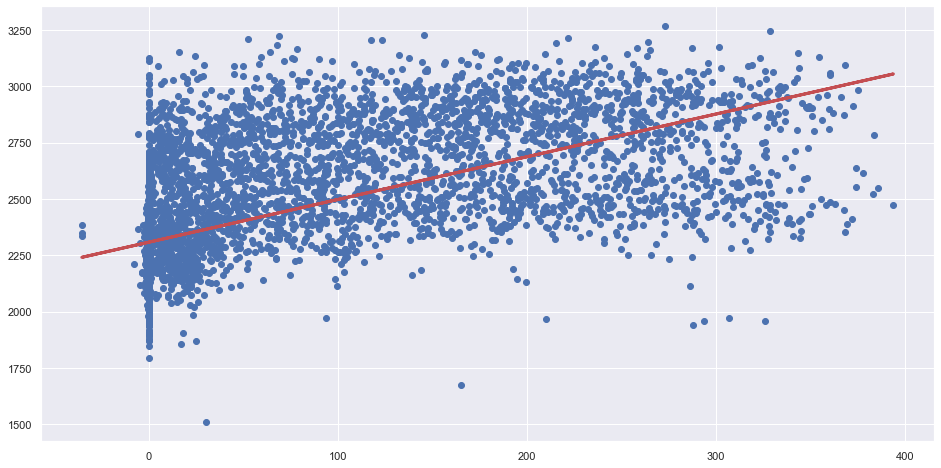

In [18]:
# Import essential models and functions from sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Recall the Total-HP Dataset
Irradiation = pd.DataFrame(NTU_Power['Building_P']) # Predictor
SBS_P = pd.DataFrame(NTU_Power['SBS_P'])               # Response


# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(Irradiation, SBS_P, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict SBS_P values corresponding to Irradiation
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Formula for the Regression line
regline_x = Irradiation
regline_y = linreg.intercept_ + linreg.coef_ * Irradiation

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

### Bad correlation

Intercept of Regression 	: b =  [188.74305984]
Coefficients of Regression 	: a =  [[-0.14533622]]

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.03805479648695986
Mean Squared Error (MSE) 	: 4684.423978496755

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.040858512080878095
Mean Squared Error (MSE) 	: 4617.355948373848



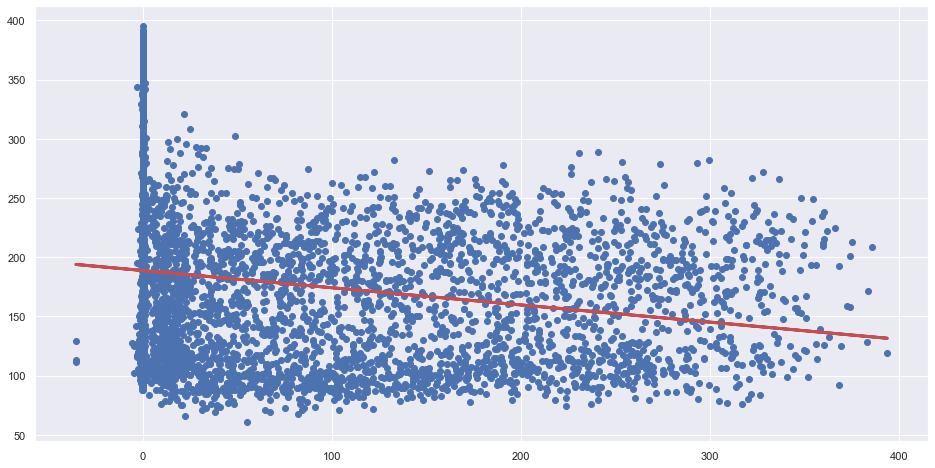

In [19]:
# Recall the Total-HP Dataset
Irradiation = pd.DataFrame(NTU_Power['Building_P']) # Predictor
HALL_4_P = pd.DataFrame(NTU_Power['HALL_4_P'])               # Response


# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(Irradiation, HALL_4_P, test_size = 0.25)

# Linear Regression using Train Data
linreg = LinearRegression()         # create the linear regression object
linreg.fit(X_train, y_train)        # train the linear regression model

# Coefficients of the Linear Regression line
print('Intercept of Regression \t: b = ', linreg.intercept_)
print('Coefficients of Regression \t: a = ', linreg.coef_)
print()

# Predict SBS_P values corresponding to Irradiation
y_train_pred = linreg.predict(X_train)
y_test_pred = linreg.predict(X_test)

# Check the Goodness of Fit (on Train Data)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_train, y_train))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_train, y_train_pred))
print()

# Check the Goodness of Fit (on Test Data)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", linreg.score(X_test, y_test))
print("Mean Squared Error (MSE) \t:", mean_squared_error(y_test, y_test_pred))
print()

# Formula for the Regression line
regline_x = Irradiation
regline_y = linreg.intercept_ + linreg.coef_ * Irradiation

# Plot the Linear Regression line
f, axes = plt.subplots(1, 1, figsize=(16, 8))
plt.scatter(X_train, y_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

It is observed how the model with good correlation between predictor and response outperforms by far the other model. Irradiation can be used for some variables in providing an edge for its ML model.

# Conclusion

Trends in NTU consumption data have been observed, and main conclusions drawn are:
- Hour, day of the week, month, and for some buildings irradiation, have been found susceptible of being good predictors. Hence, the ML model will be constructed with these variables as inputs.
- Data distribution is quite uneven and of different scale. Pre-processing could to be done before training a ML model to speed it up and increase its accuracy.
- Some of the buildings contain several outliers, and special considerations may be required when training the model for these.
- Some meter readings are wrong, being especially surprising the power of Nanyang Auditorium.
- Data presents a highly non-linear behaviour, hence a proper ML method has to be used.